In [19]:
# Copyright 2022 Spotify AB
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import gym
gym.logger.set_level(40)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import xticks

import os
import glob

from functools import partial
from numpy import genfromtxt

from utils import env_paths, evaluate_dataset


In [20]:
path_prefix = "sample-logs/" # Change this to make plots for logs generated using a fresh run.

In [21]:
def gen_names(name, suffix="_seed*/eval_reward.csv"):
    list = []
    for ds in [
        "1_512",
        "1_256",
        "1_128",
        "1_64",
        "1_32",
        "1_16",
        "1_8",
        "1_4",
        "1_2",
        "1",
        "2",
        "4",
        "8",
        "16",
    ]:
        list.append(name + ds + suffix)
    return list


def process_model_glob_log(csv_glob):
    returns = []
    for file_path in filter(os.path.isfile, list(glob.glob(csv_glob))):
        # print(f"Processing {file_path}.")
        eval_reward = genfromtxt(file_path, delimiter=",")
        eval_reward = eval_reward.reshape((-1, 2))
        returns.append(float(eval_reward[-1, 1]))
    assert len(returns) > 0
    return returns


def make_curve(
    name_string, label, env_name, xes, color, suffix="_seed*/eval_reward.csv"
):
    eval_models = gen_names(name_string, suffix)
    returns = np.array(list(map(partial(process_model_glob_log), eval_models)))
    plt.errorbar(
        xes,
        returns.mean(axis=1),
        returns.std(axis=1) / np.sqrt(returns.shape[1]),
        label=label,
        color=color,
    )


def read_expert_value(env_name, h5path):
    env = gym.make(env_name)
    dataset = env.get_dataset(h5path=h5path)
    expert_value = evaluate_dataset(dataset)
    return expert_value


def make_data_efficiency_plot(short_env_name):
    env_name, h5path = env_paths[short_env_name]
    expert_value = read_expert_value(env_name, h5path)

    xes = [
        1 / 512,
        1 / 256,
        1 / 128,
        1 / 64,
        1 / 32,
        1 / 16,
        1 / 8,
        1 / 4,
        1 / 2,
        1,
        2,
        4,
        8,
        16,
    ]

    plt.plot(xes, np.ones(len(xes)) * expert_value, label="expert", color="k")

    make_curve(
        f"{path_prefix}{env_name}/bc_model_ep",
        "BC",
        env_name,
        xes,
        color="tab:purple",
    )
    make_curve(
        f"{path_prefix}{env_name}/il_model_ep",
        "ILR",
        env_name,
        xes,
        color="tab:blue",
    )
    make_curve(
        f"{path_prefix}{env_name}/gail_model_ep",
        "GAIL",
        env_name,
        xes,
        color="tab:orange",
    )
    make_curve(
        f"{path_prefix}{env_name}/gmmil_model_ep",
        "GMMIL",
        env_name,
        xes,
        color="tab:green",
    )
    make_curve(
        f"{path_prefix}{env_name}/sqil_model_ep",
        "SQIL",
        env_name,
        xes,
        color="tab:red",
    )

    leg = plt.legend()
    plt.gca().set_xscale("log", base=2)
    plt.gcf().set_size_inches(4, 3)
    xticks([1 / 512, 1 / 128, 1 / 32, 1 / 8, 1 / 2, 2, 8, 32])
    plt.show()

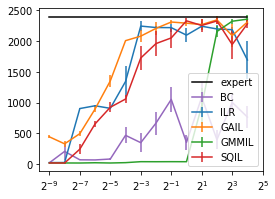

In [22]:
make_data_efficiency_plot("hopper")

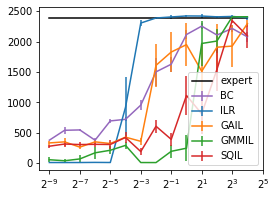

In [23]:
make_data_efficiency_plot("ant")

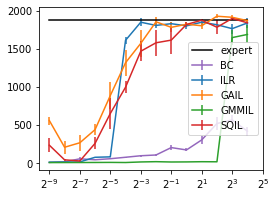

In [24]:
make_data_efficiency_plot("walker")

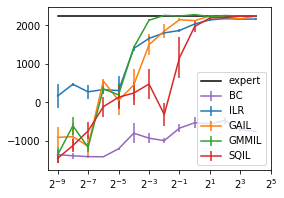

In [25]:
make_data_efficiency_plot("halfcheetah")

In [26]:
def make_sample_efficiency_plots(short_env_name):

    def plot(expert_value, glob_list, plot_title):
        plt.figure()
        for glob_path, method_name, color in glob_list:
            xes = None
            eval_rewards = []
            # print(f"Processing glob {glob_path}.")
            for file_path in filter(os.path.isfile, list(glob.glob(glob_path))):
                # print(f"Processing {file_path}.")
                eval_reward = genfromtxt(file_path, delimiter=",")
                if xes is None:
                    xes = eval_reward[:, 0]
                eval_rewards.append(eval_reward[:, 1])
            eval_rewards = np.array(eval_rewards)
            mean = eval_rewards.mean(axis=0)
            stdev = eval_rewards.std(axis=0)
            se = stdev / np.sqrt(eval_rewards.shape[0])
            plt.plot(xes, mean, label=method_name, color=color)
            plt.fill_between(xes, mean - se, mean + se, alpha=0.2, color=color)

        plt.plot(xes, np.ones(len(xes)) * expert_value, color="k", label="expert")
        plt.title(plot_title)
        plt.gcf().set_size_inches(4, 3)
        xticks([0, 250000, 500000])
        xlabels = ["{:,.2f}".format(x) + "K" for x in plt.gca().get_xticks() / 1000]
        plt.gca().set_xticklabels(xlabels)
        plt.show()
        # print("Done")

    for ep_string in [
        "16",
        "8",
        "4",
        "2",
        "1",
        "1_2",
        "1_4",
        "1_8",
        "1_16",
        "1_32",
        "1_64",
        "1_128",
        "1_256",
        "1_512",
    ]:
        env_name, h5path = env_paths[short_env_name]

        expert_value = read_expert_value(env_name, h5path)

        glob_list = [
            (
                f"{path_prefix}{env_name}/gail_model_ep{ep_string}_seed*/eval_reward.csv",
                "GAIL",
                "tab:orange",
            ),
            (
                f"{path_prefix}{env_name}/gmmil_model_ep{ep_string}_seed*/eval_reward.csv",
                "GMMIL",
                "tab:green",
            ),
            (
                f"{path_prefix}{env_name}/sqil_model_ep{ep_string}_seed*/eval_reward.csv",
                "SQIL",
                "tab:red",
            ),
            (
                f"{path_prefix}{env_name}/il_model_ep{ep_string}_seed*/eval_reward.csv",
                "ILR",
                "tab:blue",
            ),
        ]
        plot(expert_value, glob_list, f"Expert Episodes: {ep_string}")

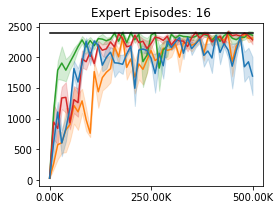

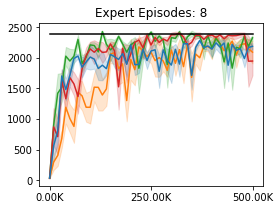

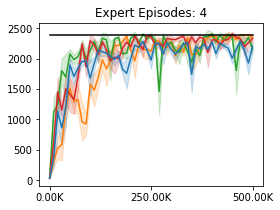

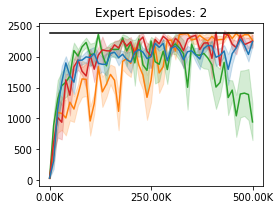

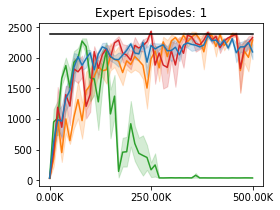

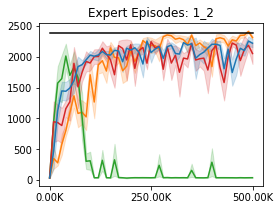

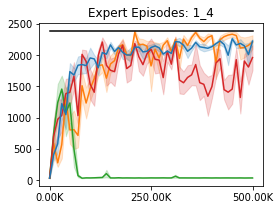

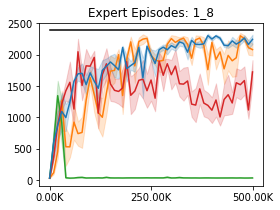

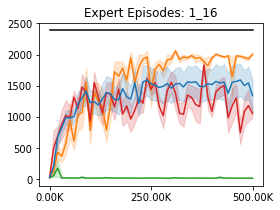

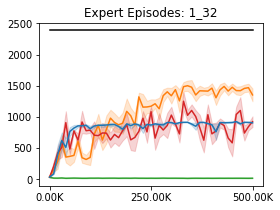

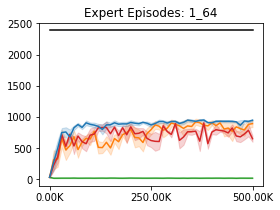

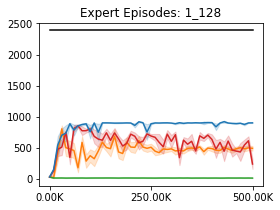

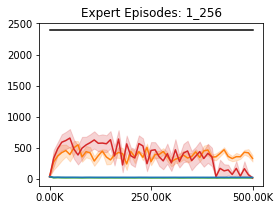

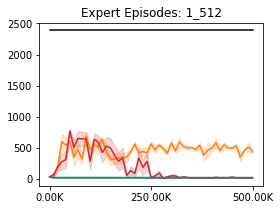

In [27]:
make_sample_efficiency_plots("hopper")


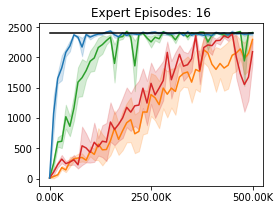

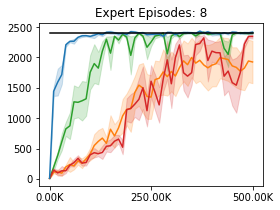

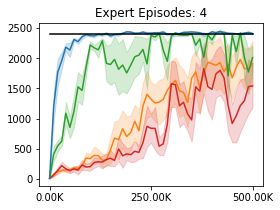

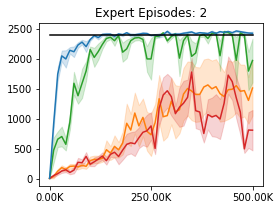

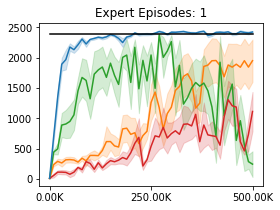

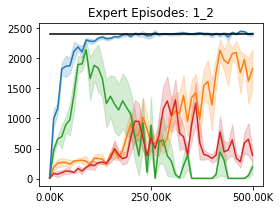

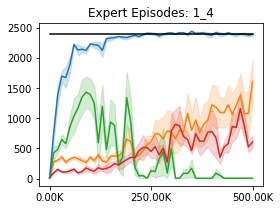

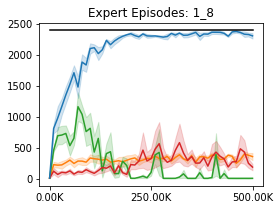

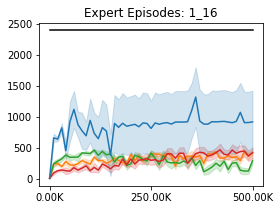

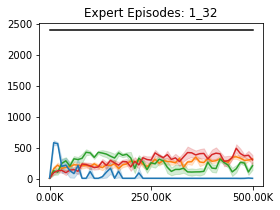

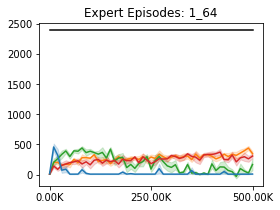

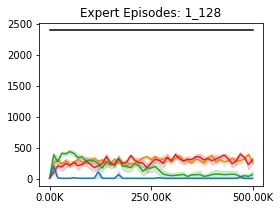

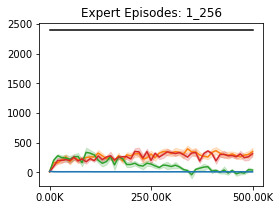

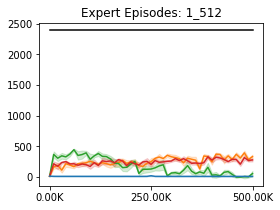

In [28]:
make_sample_efficiency_plots("ant")


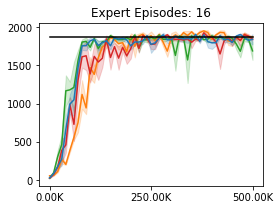

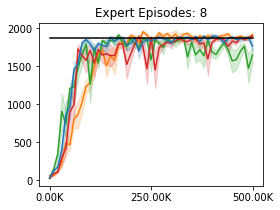

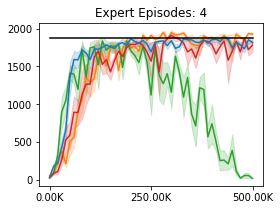

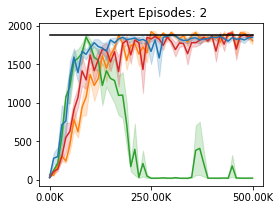

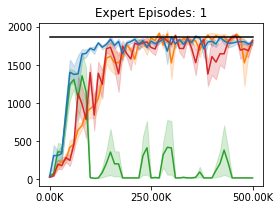

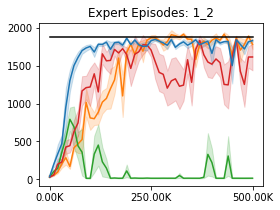

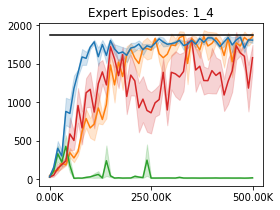

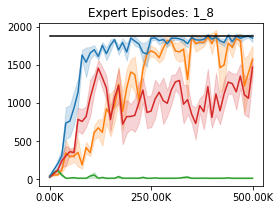

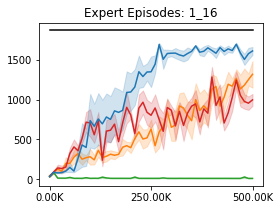

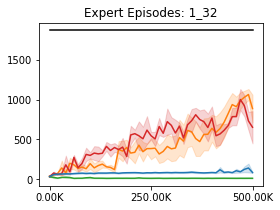

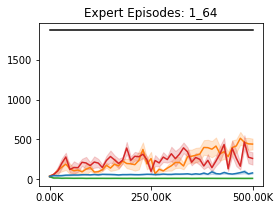

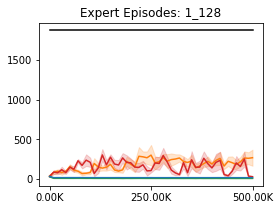

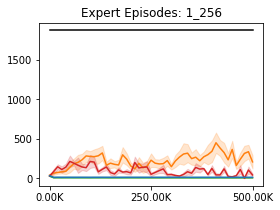

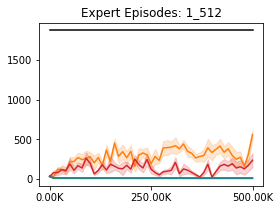

In [29]:
make_sample_efficiency_plots("walker")


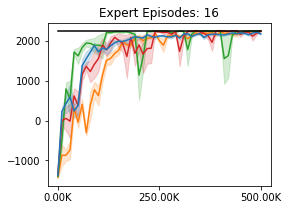

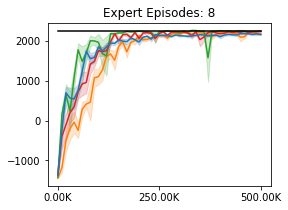

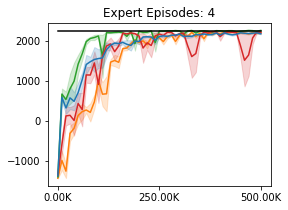

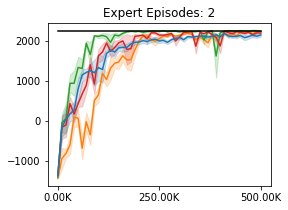

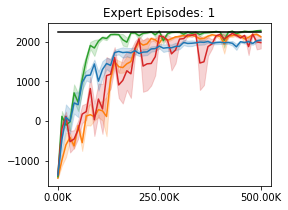

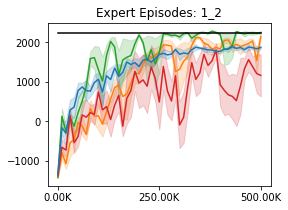

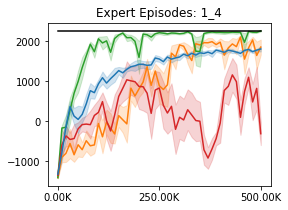

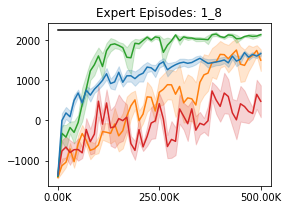

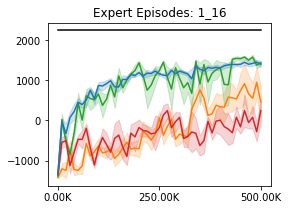

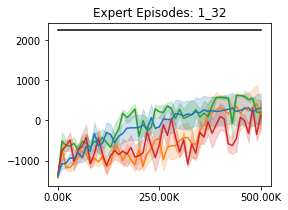

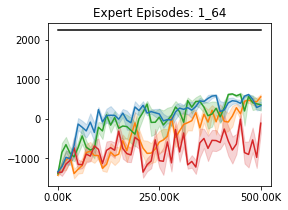

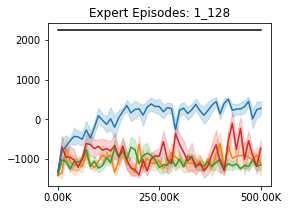

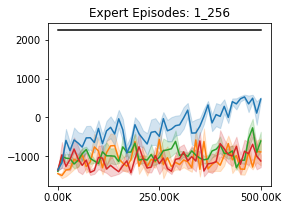

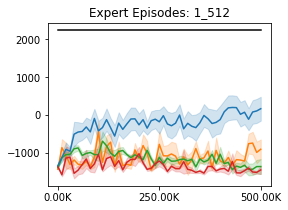

In [30]:
make_sample_efficiency_plots("halfcheetah")
